# 数据科学家纳米学位

## 卷积神经网络

## 项目：为小狗识别应用编写算法 


这个 Jupyter notebook 向你展示了优达学城最受欢迎的项目，无论在机器学习纳米学位还是人工智能纳米学位都倍受学员青睐。该项目的目标是将狗狗的图片根据品种进行分类。  

如果你想找到一个深度学习和卷积神经网络相关的且有充分指导的毕业项目的话，这就是你的首选。注意，即使你按照这个 notebook 搭建了你的分类器，你仍要写一篇博客文章或部署一个应用来满足毕业项目的要求。

注意，你其实只需要使用这个 notebook 的一部分（例如，某些代码块或数据），不需要完成整个 notebook，也能满足毕业项目的要求。

---

在此 notebook 中，我们已经为你提供一些模板代码，要成功完成此项目，你需要实现其他功能。除此之外，不需要修改所提供的代码。标题中以**（代码实现）**开头的部分表明你必须在下面的代码块中提供其他功能。我们会在每个部分提供说明，并在以 “TODO” 开头的代码块中提供实现细节。请仔细阅读说明。 

除了实现代码之外，还需要回答与项目和代码实现相关的问题。每个小节你需要回答由**'问题 X'** 开头的问题。请仔细阅读每个问题，并在**答案：**下方的文本框中填写答案。我们将根据每个问题的答案以及实现代码评估你提交的项目。

>**注意：**可以通过 **Shift + Enter** 键盘快捷键执行代码和 Markdown 单元格，并且可以通过双击单元格进入编辑模式，编辑 Markdown 单元格。

审阅标准还包含可选的“锦上添花”建议，可以指导你在满足最低要求的基础上改进项目。如果你决定实现采纳我们的建议，你应该在这个 notebook 中提供你自己的代码。



---
### 为何要完成这个项目      

在此 notebook 中，你将开发一种可用于移动应用或网络应用的算法。最终你的代码将能够接受任何用户提供的图像作为输入。如果从图像中检测出小狗，该算法将大致识别出小狗品种。如果检测出人脸，该算法将大致识别出最相似的小狗品种。下图显示了最终项目的潜在示例输出（但是我们希望每个学员的算法行为都不一样）。 

![狗狗输出示例](images/sample_dog_output.png)

在此实际应用中，你需要将一系列模型整合到一起并执行不同的任务，例如，检测图中人脸的算法与推断小狗品种的 CNN 将不一样。有很多地方都可能会出错，并且不存在完美的算法。即使你的答案不完美，也可以创造有趣的用户体验。

### 项目规划

我们将此 notebook 分成了几个独立的步骤。你可以通过以下链接浏览此 notebook。

* [第 0 步](#step0)：导入数据集
* [第 1 步](#step1)：检测人脸
* [第 2 步](#step2)：检测小狗
* [第 3 步](#step3)：（从头开始）创建分类小狗品种的 CNN
* [第 4 步](#step4)：（使用迁移学习）使用分类小狗品种的 CNN     
* [第 5 步](#step5)：（使用迁移学习）创建分类小狗品种的 CNN
* [第 6 步](#step6)：编写算法
* [第 7 步](#step7): 测试算法

---
<a id='step0'></a>


## 第 0 步：导入数据集

### 导入狗狗数据集

在下面的代码单元格中，我们将导入狗狗图片数据集我们在使用 scikit-learn 库的 `load_files` 函数时传进了很多参数：
- `train_files`, `valid_files`, `test_files` - numpy 数组，包含图片的文件路径
- `train_targets`, `valid_targets`, `test_targets` - numpy 数组，包含分类标签的独热码 
- `dog_names` - 字符串格式的狗狗品种名称列表，用于标识标签

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
#print(dog_names)

### 导入人类数据集

在下方的代码单元格中，我们导入人类数据集，文件路径被保存在 numpy 数组      `human_files` 中。

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [4]:
#print(human_files[3])

---
<a id='step1'></a>
## 第 1 步：检测人脸

我们使用 OpenCV 实现的 [Haar 特征级联分类器（Haar feature-based cascade classifiers）](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) 来检测图片中的人脸。OpenCV 提供了很多预训练的人脸检测器，它们以 XML 文件的形式存储在 [github](https://github.com/opencv/opencv/tree/master/data/haarcascades) 上。我们下载了其中一个检测器并存储在 `haarcascades` 目录中。

在下个代码单元格中，我们将演示如何使用此检测器从样本图像中检测人脸。

Number of faces detected: 1


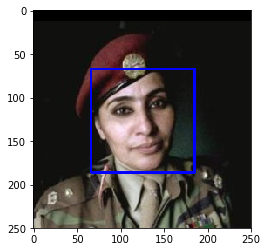

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [5]:
print(faces)

[[ 66  67 119 119]]


在使用任何人脸检测器之前，标准做法是将图像转换为灰度图像。`detectMultiScale` 函数会执行存储在 `face_cascade` 中的分类器并将灰度图像当做参数。  

在上述代码中，`faces` 是一个包含检测到的人脸的 numpy 数组，其中每行对应一张检测到的人脸。检测到的每张人脸都是一个一维数组，其中有四个条目，分别指定了检测到的人脸的边界框。数组中的前两个条目（在上述代码中提取为 `x` 和 `y`）指定了左上角边界框的水平和垂直位置。数组中的后两个条目（提取为 `w` 和 `h`）指定了边界框的宽和高。

### 编写人脸检测器

我们可以编写一个函数，如果在图像中检测到人脸，该函数将返回 `True`，否则返回 `False`。此函数称为 `face_detector`，参数为图像的字符串文件路径，并出现在以下代码块中。

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### （代码实现）评估人脸检测器

__问题 1：__ 使用以下代码单元格测试 `face_detector` 函数的性能。  
- 对于 `human_files` 中的前 100 张图像，有多少图像检测到了人脸？  
- 对于 `dog_files` 中的前 100 张图像，有多少图像检测到了人脸？ 

理想情况下，我们希望所有人脸图像都能检测到人脸，所有小狗图像都不能检测到人脸。我们的算法不能满足此目标，但是依然达到了可接受的水平。我们针对每个数据集的前 100 张图像提取出文件路径，并将它们存储在 numpy 数组 `human_files_short` 和 `dog_files_short` 中。

__答案：__
对于 'human_files' 中的前 100 张图像, 100张检测到了人脸
对于 'dog_files' 中的前 100 张图像， 11张检测到了人脸

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count = 0
dog_count = 0
for i in range(100):
    if face_detector(human_files_short[i]):
        human_count += 1
    if face_detector(dog_files_short[i]):
        dog_count +=1
print("The {} percentage of human detected as human face".format(human_count))
print("The {} percentage of dog detected as human face".format(dog_count))

The 100 percentage of human detected as human face
The 11 percentage of dog detected as human face


__问题 2：__ 所选的算法使得我们需要告诉用户我们对上传图片有要求，图片中的人脸必须清晰（避免触怒某些急性子用户）。我们期望用户能够配合，你认为这样的期望合理吗？如果你认为不合理，能否想出一种不需要用户上传的图片中必须有清晰人脸的人脸检测方法？

__答案：__
不合理，可以在训练模型时，采用数据增强

建议在算法中使用 OpenCV 的人脸检测器来检测人脸图像，但是你也可以尝试其他方法，尤其是利用深度学习的方法:)。请在以下代码单元格中设计并测试你自己的人脸检测算法。如果你打算深入 _选做（Optional）_ 任务，记得报告每个数据集上的表现。

In [9]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## 第 2 步：检测小狗

在这一小节，我们使用预训练的 [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) 模型来检测图片中的狗狗。我们的第一行代码下载了 ResNet-50 模型，以及在 [ImageNet](http://www.image-net.org/) 预训练后的权重信息。ImageNet 是一个庞大且常用的数据集，用于图像分类和其他视觉任务。ImageNet 包含 1000 万以上的 URL，每个都链接到包含某个对象的图像，这些对象分成了 [1000 个类别](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)。输入一个图片，预训练的 ResNet-50 模型预测图片中包含了什么物体，并返回对应的标签（标签是 ImageNet 内置的一些类别）。

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### 预处理数据     

当后端使用 TensorFlow 时，Keras CNN 要求输入的是一个 4D 的 numpy 数组（我们也称之为 4 维张量），其形状为：

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

其中 `nb_samples` 表示图片 (或样本) 的数量， `rows`、 `columns` 和 `channels` 表示每个图片各自的行数、列数和通道数。  

`path_to_tensor` 函数接受一个彩色图片的文件路径字符串，返回一个适用于 Keras CNN 训练的四维张量。这个函数首先加载图片，然后将其重新调整为 $224 \times 224$ 像素的形状。接下来，图片被转成 numpy 数组，之后被整理成 4D 张量。在这个案例中，因为我们处理的是彩色图片，每个图片有 3 个通道。还有，我们处理的是单张图片，返回的张量的形状就是：

$$
(1, 224, 224, 3).
$$

`paths_to_tensor` 函数接受一个图片路径的字符串 numpy 数组，返回一个四维张量。该张量的形状是：  

$$
(\text{nb_samples}, 224, 224, 3).
$$

其中，`nb_samples` 是输入的图片路径中对应的样本数，或者说图片的数目。建议你把 `nb_samples` 认为是 3 维张量的数量（每个 3 维张量就对应数据集里的一张图片） 。

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 用 ResNet-50 进行预测

将要输入 ResNet-50 的 4 维向量准备好后，任何 Keras 中其他的预训练过的模型需要一些额外的步骤。首先，RGB 图像的通道要重排，以转换成 BGR。所有预训练的模型都需要再进行归一化，即必须将每张图片的每个像素都减去平均像素值（$[103.939, 116.779, 123.68]$ ，按 RGB 顺序排列，是用 ImageNet 中所有图像的像素值计算得到的）。上述功能在导入的 `preprocess_input` 函数进行代码实现。如果想了解更多，可以参考 `preprocess_input` 的代码[链接](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

现在我们已经准备好输入 ResNet-50 的数据了，可以开始使用该模型来提取特征了。该功能通过 `predict` 方法实现。该方法会返回一个 numpy 数组。该数组的第 $i$ 项数值表示该模型预测此图片属于第 $i$ 个 ImageNet 分类的概率。这个功能在下面的 `ResNet50_predict_labels` 函数进行代码实现。

通过对预测概率向量取 argmax，我们得到一个整数，该整数表示该图片所属的类别的序号，我们可以使用这个[字典](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)找到类别名称。

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 写一个小狗检测器

查看该[字典](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)后，你将发现：小狗对应的类别按顺序排列，对应的键是 151-268（含），包含从 `'Chihuahua'` 到 `'Mexican hairless'` 的所有类别。因此，为了检查某张图片是否由预训练的 ResNet-50 模型检测到狗狗，我们仅仅需要检查上面的`ResNet50_predict_labels` 函数是否返回了介于 151 和 268 之间的一个数（含边界值）。

我们顺着该思路完成下面的 `dog_detector` 函数，如果检测到图片中有狗狗，它会返回 `True` （如果没有，返回 `False` ）。

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### （代码实现）评估小狗检测器

__问题 3：__ 在以下代码单元格中测试 `dog_detector` 的效果。  
- 对于 `human_files_short` 中的图像，有多少图像检测到了小狗？  
- 对于 `dog_files_short` 中的图像，有多少图像检测到了小狗？

__答案：__
对于 `human_files_short` 中的图像，有0个图像检测到了小狗？  
对于 `dog_files_short` 中的图像，有100%的图像检测到了小狗？

In [80]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_count2 = 0
dog_count2 = 0
for i in range(100):
    if dog_detector(human_files_short[i]):
        human_count2 += 1
    if dog_detector(dog_files_short[i]):
        dog_count2 +=1
print("The {}  of humans detected as humans".format(human_count2))
print("The {}  of dogs detected as dogs".format(dog_count2))

The 0  of humans detected as humans
The 100  of dogs detected as dogs


---
<a id='step3'></a>
## 第 3 步：（从头开始）创建分类小狗品种的 CNN

创建好从图像中检测人脸和小狗的函数后，我们需要预测图像中的小狗品种。在这一步，你需要创建一个分类小狗品种的 CNN。你必须从头创建一个 CNN（因此暂时不能使用迁移学习），并且测试准确率必须至少达到 1%。在此 notebook 的第 5 步，你将使用迁移学习创建 CNN，并且能够获得很高的准确率。

谨慎添加可训练的层！更多的参数意味着更多的训练时长，意味着你更可能需要 GPU 来加速训练过程。幸运的是，Keras 提供了每个周期（epoch）训练时间的简单估计，你可以用这个乘以训练次数得到训练整个模型的时间。 

预测图中小狗的品种是一项非常难的挑战。因为 **即使人类** 要分辨布列塔尼猎犬（Brittany）和威尔斯激飞猎犬（Welsh Springer Spaniel）也很困难。  

布列塔尼猎犬 | 威尔斯激飞猎犬
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

还有很多其他相似的狗品种（例如卷毛寻回犬 Curly-Coated Retrievers 和美国水猎犬 American Water Spaniels）。  

卷毛寻回犬 | 美国水猎犬
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


还有，拉布拉多有黄色、巧克力色和黑色品种。基于视觉的算法需要克服这种同一类别差异很大的问题，并决定如何将所有这些不同肤色的小狗分类为相同的品种。  

黄色拉布拉多 | 巧克力色拉布拉多 | 黑色拉布拉多
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

随机猜测的效果很差：除了类别数量不太平衡之外，随机猜测的正确概率约为 1/133，准确率不到 1%。  

在深度学习领域，实践比理论知识靠谱得到。请尝试多种不同的架构，并相信你的直觉。希望你可以从学习中获得乐趣！ 

### 预处理数据

我们通过将每个图像中的每个像素除以 255 来重新缩放图像。

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:13<00:00, 59.92it/s]


In [14]:
train_tensors[1]

array([[[ 0.63137257,  0.38431373,  0.01960784],
        [ 0.63529414,  0.3882353 ,  0.02352941],
        [ 0.63137257,  0.38431373,  0.01176471],
        ..., 
        [ 0.47450981,  0.08627451,  0.00392157],
        [ 0.45490196,  0.09019608,  0.00392157],
        [ 0.47450981,  0.10980392,  0.01960784]],

       [[ 0.63529414,  0.3882353 ,  0.02352941],
        [ 0.63137257,  0.38431373,  0.01960784],
        [ 0.63921571,  0.39215687,  0.01960784],
        ..., 
        [ 0.48235294,  0.09019608,  0.01176471],
        [ 0.45882353,  0.08627451,  0.        ],
        [ 0.47450981,  0.10588235,  0.01176471]],

       [[ 0.63529414,  0.3882353 ,  0.02352941],
        [ 0.63137257,  0.38431373,  0.01960784],
        [ 0.64313728,  0.39607844,  0.02352941],
        ..., 
        [ 0.48235294,  0.09019608,  0.01176471],
        [ 0.45882353,  0.07450981,  0.        ],
        [ 0.46666667,  0.08627451,  0.        ]],

       ..., 
       [[ 0.21176471,  0.10980392,  0.05098039],
        

### （代码实现）模型架构

创建分类小狗品种的 CNN。在代码单元格的末尾，使用下面的命令来展示模型概述信息：
    
        model.summary()

我们已经导入了部分 Python 模块方便你开始，你也可以自由添加你想要添加的模块。如果你卡住了，这里提醒一下，你的模型应该做到在 CPU 上训练相对较快并且训练 5 个周期（epoch）内的准确率 >1%：

![CNN样例](images/sample_cnn.png)
           
__问题 4：__ 列出获得最终 CNN 结构的步骤以及每步的推理过程。如果你选择使用上述的结构，描述你为什么认为该 CNN 架构会在这个图像分类任务中表现优秀。

__答案：__
第一层的16个filters识别底层特征，比如边界。图片是224*224且为三通道的，所以input_shape是（224，224，3）。第二层的filter是识别复杂度高一些的特征，比如形状。第三层识别更为复杂的特征。所有的池化层是减少计算复杂度的。因为狗有133个品种，所以最后的输出层为133个节点。

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(GlobalAveragePooling2D())
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(133, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       32896     
__________

### 编译模型

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### （代码实现）训练模型

在下面的代码单元格中训练你的模型。使用模型检查点来保存验证损失最低的模型信息。

欢迎你[增加训练数据](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，但这不是必须的。

In [17]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 24s 4ms/step - loss: 4.8824 - acc: 0.0084 - val_loss: 4.8626 - val_acc: 0.0168
Epoch 2/5
6680/6680 [==============================] - 24s 4ms/step - loss: 4.8207 - acc: 0.0153 - val_loss: 4.7497 - val_acc: 0.0168
Epoch 3/5
6680/6680 [==============================] - 24s 4ms/step - loss: 4.7386 - acc: 0.0166 - val_loss: 4.6952 - val_acc: 0.0192
Epoch 4/5
6680/6680 [==============================] - 24s 4ms/step - loss: 4.6882 - acc: 0.0175 - val_loss: 4.6440 - val_acc: 0.0216
Epoch 5/5
6680/6680 [==============================] - 24s 4ms/step - loss: 4.6462 - acc: 0.0219 - val_loss: 4.6105 - val_acc: 0.0251


### 加载验证损失最低的模型

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 训练模型

在小狗图像测试数据集上尝试模型。确保测试准确率高于 1%。

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.5120%


---
<a id='step4'></a>
## 第 4 步：使用 CNN 分类小狗品种

为了在不牺牲准确率的情况下减少训练时间，我们将向你展示如何使用迁移学习的方法训练 CNN。在下面的步骤中，你将亲自动手用迁移学习的方法训练自己的 CNN。

### 获取瓶颈特征（bottleneck feature）

In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [21]:
print(bottleneck_features)

### 模型架构

这个模型使用预训练的 VGG-16 模型作为固定的特征提取器（fixed feature extractor），也就是说，VGG-16 的最后一层卷积层的输出会作为我们模型的输入。我们仅仅加入了一层全局平均池化层（global average pooling layer）和一个全连接层（fully connected layer），后者包含一个节点，该节点和所有狗狗品种的节点相连，并使用 softmax 激活函数。

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### 编译模型

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 训练模型

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 308us/step - loss: 12.6607 - acc: 0.1124 - val_loss: 11.2042 - val_acc: 0.2072
Epoch 2/20
6680/6680 [==============================] - 2s 262us/step - loss: 10.4327 - acc: 0.2741 - val_loss: 10.3301 - val_acc: 0.2743
Epoch 3/20
6680/6680 [==============================] - 2s 254us/step - loss: 9.9152 - acc: 0.3380 - val_loss: 10.1867 - val_acc: 0.2970
Epoch 4/20
6680/6680 [==============================] - 2s 289us/step - loss: 9.6050 - acc: 0.3659 - val_loss: 9.8634 - val_acc: 0.3162
Epoch 5/20
6680/6680 [==============================] - 2s 260us/step - loss: 9.4091 - acc: 0.3868 - val_loss: 9.7711 - val_acc: 0.3353
Epoch 6/20
6680/6680 [==============================] - 2s 265us/step - loss: 9.1795 - acc: 0.3958 - val_loss: 9.3867 - val_acc: 0.3509
Epoch 7/20
6680/6680 [==============================] - 2s 283us/step - loss: 8.9814 - acc: 0.4186 - val_loss: 9.3557 - val_acc: 0.3

### 加载验证损失最低的模型

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 训练模型

现在你可以使用 CNN 来测试它在测试集上识别狗狗品种的表现如何了。我们在下面打印出准确率结果。

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.2249%


In [47]:
#for i in range(10):
#    print(VGG16_predictions[i])

In [44]:
#test_VGG16[0]

### 使用模型预测狗狗的品种

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## 第 5 步：（使用迁移学习）创建分类小狗品种的 CNN

现在你将使用迁移学习创建能够识别图中小狗品种的 CNN。你的 CNN 必须在测试集上至少达到 60% 的准确率。

在第 4 步，我们用迁移学习技术从 VGG-16 瓶颈特征创建了一个 CNN 。在这一节，我们要用到不同的预训练的模型的瓶颈特征。为了让任务更简单些，我们预先计算了所有 Keras 实现了的网络的特征：
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) 瓶颈特征
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) 瓶颈特征
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) 瓶颈特征
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) 瓶颈特征

文件名的格式满足：

    Dog{network}Data.npz
    
其中上面 `{network}` 的模型名可以是 `VGG19`、 `Resnet50`  、`InceptionV3` 或 `Xception` 的任意一个。上述的模型架构中选择一个，下载对应的瓶颈特征，然后把下载的文件放入 `bottleneck_features/` 文件夹中。

'/home/workspace/dog-project'

### （代码实现） 获取瓶颈特征（bottleneck feature）

在下方的代码块中，用如下函数提取训练、测试和验证集的瓶颈特征：

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']
    

In [28]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### （代码实现）模型架构

创建分类小狗品种的 CNN。在代码单元格末尾，运行下面这行代码返回模型的概述信息：

In [ ]:
<your model's name>.summary()

__问题 5：__列出获得最终 CNN 结构的步骤以及每步的推理过程。解释为何该结构适合解决手头的问题。

__答案：__

In [29]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### （代码实现） 编译该模型

In [30]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### （代码实现） 训练模型

在下面的代码单元格中训练模型。使用模型检查点来保存验证损失最低的模型。  

欢迎你[增加训练数据](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，但这不是必须的。

In [31]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 286us/step - loss: 1.6329 - acc: 0.5982 - val_loss: 0.8649 - val_acc: 0.7341
Epoch 2/20
6680/6680 [==============================] - 2s 240us/step - loss: 0.4380 - acc: 0.8657 - val_loss: 0.6787 - val_acc: 0.7892
Epoch 3/20
6680/6680 [==============================] - 1s 224us/step - loss: 0.2639 - acc: 0.9204 - val_loss: 0.7272 - val_acc: 0.7892
Epoch 4/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1698 - acc: 0.9491 - val_loss: 0.6858 - val_acc: 0.8012
Epoch 5/20
6680/6680 [==============================] - 2s 238us/step - loss: 0.1249 - acc: 0.9612 - val_loss: 0.6571 - val_acc: 0.8192
Epoch 6/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.0888 - acc: 0.9735 - val_loss: 0.7193 - val_acc: 0.8048
Epoch 7/20
6680/6680 [==============================] - 2s 244us/step - loss: 0.0636 - acc: 0.9817 - val_loss: 0.7291 - val_acc: 0.8156
E

### （代码实现）加载验证损失最低的模型

In [32]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### （代码实现）测试模型

在小狗图像测试数据集上尝试模型。确保测试准确率高于 60%。

In [54]:
### TODO: Calculate classification accuracy on the test dataset.
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.9474%


### （代码实现）使用模型预测小狗品种

编写一个函数，它会将图像路径作为输入，并返回模型预测的小狗品种（`Affenpinscher`、`Afghan_hound` 等）。  

类似于第 5 步的函数，你的函数应该分 3 步：
1. 提取所选择的 CNN 模型的瓶颈特征。
2. 将瓶颈特征作为模型的输入返回预测向量。注意预测向量的 argmax 就是预测的狗狗品种的序号。
3. 使用 notebook 中第 0 步定义的 `dog_names` 数组来返回对应的狗狗品种。

用来提取瓶颈特征（即利用网络的卷积层部分，把全连接以上的部分抛掉。然后在我们的训练集和测试集上跑一遍，将得到的输出。即网络在全连接之前的最后一层激活的 feature map）的函数可以在 `extract_bottleneck_features.py` 找到，并且它们已经在前面的单元格中导入了。为了得到你的 CNN 的瓶颈特征，你需要使用函数：

In [34]:
extract_Resnet50

<function extract_bottleneck_features.extract_Resnet50(tensor)>

其中上面的 `{network}` 模型名应该是 `VGG19`、`Resnet50`、`InceptionV3` 和 `Xception` 其中之一。

In [51]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def dog_breed_detector(img_path):
    bottlenect_feature = extract_Resnet50(path_to_tensor(img_path))
    predicted_vector = Resnet50_model.predict(bottlenect_feature)
    return dog_names[np.argmax(predicted_vector)]
    

In [46]:
#extract_Resnet50(path_to_tensor("/home/workspace/dog-project/images/sample_human_output.png"))

array([[[[ 0.        ,  0.01168795,  0.18479024, ...,  0.08167343,
           0.0186125 ,  0.11123385]]]], dtype=float32)

In [48]:
#bottlenect_feature= extract_Resnet50(path_to_tensor("/home/workspace/dog-project/images/sample_human_output.png"))
#bottlenect_feature

array([[[[ 0.        ,  0.01168795,  0.18479024, ...,  0.08167343,
           0.0186125 ,  0.11123385]]]], dtype=float32)

In [50]:
#Resnet50_model.predict(bottlenect_feature)
    

array([[  1.52025628e-03,   1.22065167e-03,   4.28240492e-05,
          1.73995883e-04,   8.18971603e-06,   2.01212671e-07,
          1.61420947e-04,   3.83097329e-03,   6.01158012e-04,
          6.94647315e-04,   9.50103367e-06,   4.24564816e-03,
          2.58770050e-03,   2.26176098e-06,   8.84639565e-03,
          2.96180546e-02,   2.14022657e-04,   5.92727474e-06,
          5.49839626e-07,   2.77126557e-04,   8.44120436e-08,
          4.92005958e-04,   3.91814865e-08,   7.83698561e-05,
          2.62915887e-06,   9.13127133e-06,   7.83833093e-05,
          5.27588568e-08,   9.93558391e-09,   1.40640870e-04,
          1.43708767e-05,   5.56754938e-04,   2.64114380e-04,
          1.58239622e-04,   1.20383092e-07,   4.32433153e-05,
          1.22375968e-06,   3.70747559e-02,   1.32902365e-04,
          3.04706657e-04,   2.67913751e-03,   1.44657621e-04,
          1.44785771e-03,   8.34987804e-05,   7.61905394e-05,
          9.70930699e-03,   5.81301028e-05,   1.17296325e-02,
        

In [52]:
dog_breed_detector("/home/workspace/dog-project/images/sample_human_output.png")

'ages/train/110.Norwegian_lundehund'

---
<a id='step6'></a>
## 第 6 步：编写算法

编写一个算法，它会将图像的文件路径作为输入，并首先判断图像中是否包含人脸、小狗，或二者都不含。然后，
- 如果在图像中检测到了__小狗__，则返回预测的品种。
- 如果在图像中检测到了__人脸__，则返回相似的小狗品种。
- 如果二者都没检测到，则输出错误消息。

你可以自己编写从图像中检测人脸和小狗的函数，当然也可以使用上面开发的 `face_detector` 和 `dog_detector` 函数。你**必须**使用在第 5 步创建的 CNN 预测小狗品种。  

下方是函数所需的输入样本图片和输出 ，你也可以自由地设计流程获得更好的用户体验。

![人脸样本输出](images/sample_human_2.png)

这张图片看起来像     阿富汗猎犬（Afghan Hound）。
### （代码实现）编写算法

In [73]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def show_result(path, title):   

    fig, ax = plt.subplots()
    ax.imshow(Image.open(path))
    ax.axis('off')
    ax.set_title(title)
    return ax


def human_dog_detector(img_path):
    #im = Image.open(img_path, 'r')
    #plt.imshow(np.array(im))
    
    if dog_detector(img_path):
        dog_breed = dog_breed_detector(img_path)
        #print("this picture looks like {}".format(clean_string(dog_breed)))
        #result = "This picture looks like {}".format(dog_breed)
        result = "This picture looks like " + dog_breed.split(".")[-1]
    elif face_detector(img_path):
        dog_breed = dog_breed_detector(img_path)
        #print("this picture looks like {}".format(clean_string(dog_breed)))
        #result = "The most resembling dog breed of this person in the picure is {}".format(dog_breed)
        result = "The most resembling dog breed of this person in the picure is " + dog_breed.split(".")[-1]
        
    else:
        result = "This picture does not include human or dog"
    return result

def pred_show_breed(path):

    show_result(path, human_dog_detector(path))




---
<a id='step7'></a>
## 第 7 步：测试算法

在此部分中，你可以尽情测试新算法啦！ 算法认为 __这__ 看起来和哪个品种的狗狗比较像？如果你有一只狗，算法能准确预测出小狗的品种吗？如果你有一只猫，算法会错误地认为这只猫是小狗吗？

### （代码实现）在样本图像上测试算法。

至少在计算机上用 6 张图像测试你的算法。你可以使用任何图像。至少测试两张人脸图像和两张小狗图像。  

__问题 6：__ 结果比你预期的要好吗 :)？ 还是更糟糕 :(？请对你的算法提出至少三个值得改进的地方。

__答案：__ 

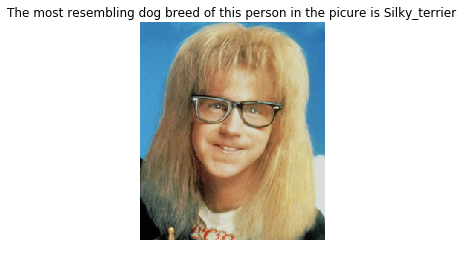

In [74]:

## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
#human_dog_detector("/home/workspace/dog-project/images/")
pred_show_breed("/home/workspace/dog-project/images/sample_human_2.png")

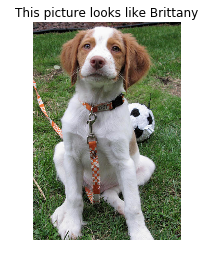

In [75]:
pred_show_breed("/home/workspace/dog-project/images/Brittany_02625.jpg")

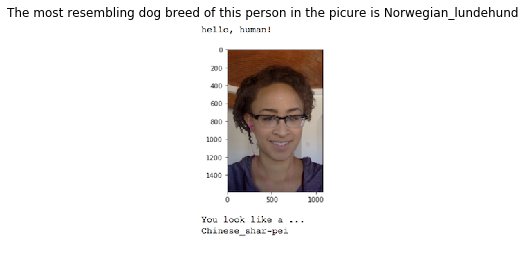

In [76]:
pred_show_breed("/home/workspace/dog-project/images/sample_human_output.png")

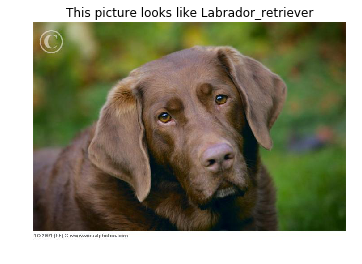

In [77]:
pred_show_breed("/home/workspace/dog-project/images/Labrador_retriever_06455.jpg")

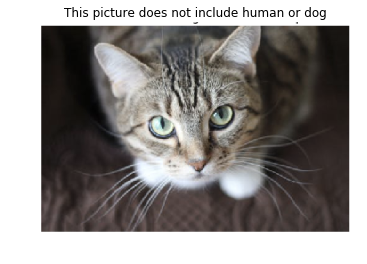

In [68]:
pred_show_breed("/home/workspace/dog-project/images/cat.png")